1.) Imports

In [82]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

2.) Load Data

In [84]:
# Check the current working directory
print("Current working directory:", os.getcwd())

# Set the working directory
os.chdir('C:/Users/ambue/OneDrive/Documents/Working_Directory')  # Replace with your own desired path
print("New working directory:", os.getcwd())

# Set File Path
file_path = r"C:\Users\ambue\OneDrive\Documents\Working_Directory\Analysis_Data.xlsx"

# Load Drill Cost Data
df_drillCost = pd.read_excel(file_path, sheet_name='Drilling Cost', skiprows=2)

# Load Oil Price Data
df_projection = pd.read_excel(file_path, sheet_name='Price Projections', skiprows=2)

Current working directory: C:\Users\ambue\OneDrive\Documents\Working_Directory
New working directory: C:\Users\ambue\OneDrive\Documents\Working_Directory


3.) Simulation Parameters

In [86]:
# Number of simulations
simSize = 100000
np.random.seed(2222002)  # Set seed for reproducibility

4.) Compute Drilling Costs

In [88]:
# Initial Drilling Cost from 2006-06-30 (using historical return distribution)
P0 = df_drillCost[df_drillCost['Date'] == '2006-06-30'].iloc[:, 1:4].mean(axis=1).item() * 1000

data = []

# Apply stochastic process to project drilling costs forward
for i in range(simSize):
    Pt = P0
    for j in range(5):  # 2006-2012 (normal distribution)
        ret = np.random.normal(loc=0.131, scale=0.178)
        Pt *= (1 + ret)
    for j in range(3):  # 2012-2015 (triangular distribution)
        ret = np.random.triangular(-0.22, -0.0917, -0.07)
        Pt *= (1 + ret)
    for j in range(10):  # 2015-2025 (triangular distribution)
        ret = np.random.triangular(0.02, 0.05, 0.06)
        Pt *= (1 + ret)

    data.append(Pt)

# Convert to NumPy array
drilling = np.array(data)

5.) Compute Year 0 Costs

In [90]:
# Seismic & Lease Costs
seismic = np.random.normal(loc=3, scale=0.35, size=simSize)
lease = np.random.normal(loc=600, scale=50, size=simSize)

# Completion Costs
completion = np.random.normal(loc=390000, scale=50000, size=simSize)

# Professional Overhead
overhead = np.random.triangular(172000, 215000, 279000, size=simSize)

# Total Dry Well Cost
dryWell = drilling + seismic * 43000 + lease * 960 + overhead

6.) Compute Initial Production and Decline Rate

In [92]:
# Lognormal to Normal Transformation
LogAverage = 420
LogStdDev = 120
SigmaNormal = np.sqrt(np.log(1 + (LogStdDev / LogAverage) ** 2))
MeanNormal = np.log(LogAverage) - SigmaNormal ** 2 / 2

# Initial Production (IP)
IP = np.random.lognormal(mean=6, sigma=0.28, size=simSize)

# Decline Rate
decline = np.random.uniform(low=0.15, high=0.32, size=simSize)

# Enforce Correlation Between IP & Decline Rate
corr_matrix = np.array([[1, 0.64], [0.64, 1]])
chol_decomp = la.cholesky(corr_matrix, lower=False)

# Standardization Functions
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

def destandardize(x_std, x):
    return (x_std * np.std(x)) + np.mean(x)

# Apply Correlation
Both_rate = np.array([standardize(IP), standardize(decline)])
bend = chol_decomp @ Both_rate
final_rate = np.array([destandardize(bend[0], IP), destandardize(bend[1], decline)])

7.) Compute Revenue Interest and Initalize Net Present Value (NPV)

In [94]:
# Revenue Interest
interest = np.random.normal(loc=0.75, scale=0.02, size=simSize)

# Start NPV Calculation with Year 0 Costs
npv = np.array(dryWell + completion)

8.) Forecast Future Revenues (15-Year Projection)

In [96]:
# Forecast for 15 Years
for i in range(15):
    yearBegin = np.array(final_rate[0])
    yearEnd = yearBegin * (1 - final_rate[1])
    production = 365 * (yearBegin + yearEnd) / 2

    # Oil Price Forecast (Dynamic for Each Year)
    low = df_projection[df_projection['Year'] == 2026 + i]['Low Oil Price'].item()
    high = df_projection[df_projection['Year'] == 2026 + i]['High Oil Price'].item()
    exp = df_projection[df_projection['Year'] == 2026 + i]['AEO2023 Reference'].item()
    price = np.random.triangular(low, exp, high, size=simSize)

    # Net Revenue & Severance Tax
    revenue = production * price * interest * (1 - 0.046)

    # Operating Cost
    operate = np.full(simSize, np.random.normal(loc=2.25, scale=0.3), dtype=float)

    # Apply Correct Discounting for NPV
    npv += (revenue - operate - overhead) / (1.1 ** (i + 1))
    final_rate[0] = yearEnd

9.) Convert NPV to Millions and Visualize Distribution

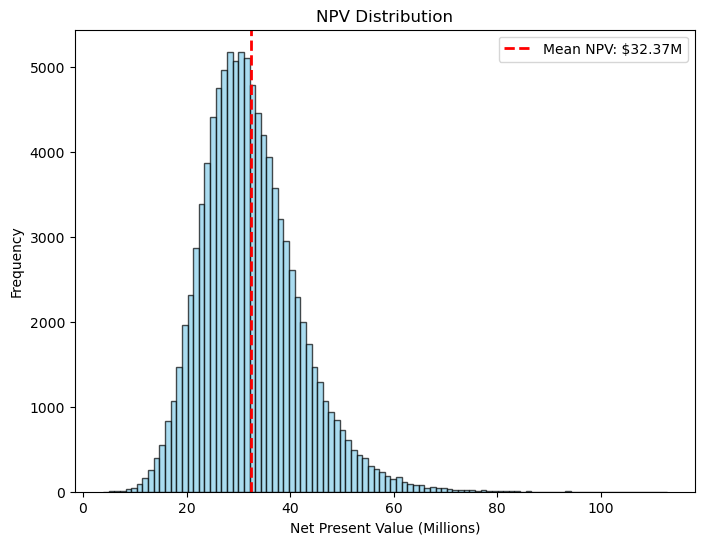

  Statistic         NPV
0      Mean   32.373793
1    Median   31.326792
2   Std Dev    9.324605
3       Min    3.870455
4       Max  112.686741
Simulation complete. Results saved to 'npv_results.csv'.


In [117]:
# Convert NPV to Millions
npv_millions = npv / 1_000_000

# Define the file path to save the image
plot_filename = "npv_distribution.png" 

# Histogram of NPV
plt.figure(figsize=(8,6))
plt.hist(npv_millions, bins=100, color="skyblue", alpha=0.7, edgecolor="black")
plt.axvline(np.mean(npv_millions), color="red", linestyle="dashed", linewidth=2, label=f"Mean NPV: ${np.mean(npv_millions):,.2f}M")
plt.xlabel("Net Present Value (Millions)")
plt.ylabel("Frequency")
plt.title("NPV Distribution")
plt.legend()

# Save the plot before displaying it
plt.savefig(plot_filename, dpi=300, bbox_inches="tight")

#Sh
plt.show()

# Summary Statistics
summary_stats = pd.DataFrame({
    "Statistic": ["Mean", "Median", "Std Dev", "Min", "Max"],
    "NPV": [np.mean(npv_millions), np.median(npv_millions), np.std(npv_millions), np.min(npv_millions), np.max(npv_millions)]
})

print(summary_stats)

# Save results
npv_df = pd.DataFrame({"NPV (Millions)": npv_millions})
npv_df.to_csv("npv_results.csv", index=False)

print("Simulation complete. Results saved to 'npv_results.csv'.")